# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

df = pd.read_csv('data/human_body_temperature.csv')

#start by taking a quick look at the data
print(df.shape)
df.head()

(130, 3)


,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


### 1. Is the distribution normal?

A quick histogram will give us a decent look at how normal it is.

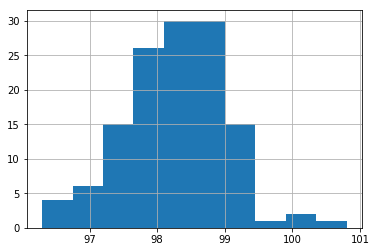

In [5]:
#plot a quick histogram
df['temperature'].hist()

Definitely normal-ish. Kinda hard to tell though with the big drop off around 99.5. I want to visually compare the cumulative histogram with a normal cdf to be more precise.

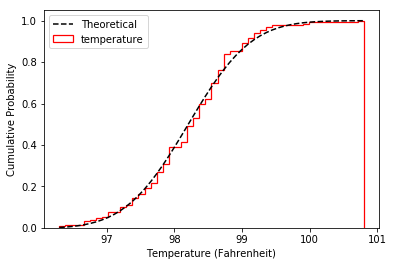

In [40]:
#use cumulative=True to plot a cumulative histogram
n,bins,patches=plt.hist(df.temperature,bins=50,cumulative=True,histtype='step',
                        label='temperature',density=True,color='r',linewidth=1.25)

#plot a normal cdf with the same mean, standard deviation
#code taken from https://matplotlib.org/3.1.0/gallery/statistics/histogram_cumulative.html
m=df.temperature.mean()
s=df.temperature.std()
y = ((1 / (np.sqrt(2 * np.pi) * s)) *
     np.exp(-0.5 * (1 / s * (bins - m))**2))
y = y.cumsum()
y /= y[-1]

plt.plot(bins, y, 'k--', linewidth=1.5, label='Theoretical')
plt.legend()
plt.xlabel('Temperature (Fahrenheit)')
plt.ylabel('Cumulative Probability')

plt.show()

I could run more comparisons, but I definitely feel comfortable saying this is a normal distribution now.

### 2. Is the sample size large? Are the observations independent?

130 data points is more than 30, so the central limit theorem is satisfied. The fact that the data come from a medical journal suggests that the observations are independent.

### 3. Is the true population mean really 98.6 degrees F?

Bootstrap method first. 

I'm taking 10,000 bootstrap samples and recording the mean of each sample.

In [35]:
#size is the number of samples
size=10**4

#pre-allocating memory for the sample means to save on computation speed
bootstrap_means=np.empty(size)

#perform 10,000 iterations
for i in range(size):
    #draw a new bootstrap sample with the same size as the actual sample
    bootstrap_samples=df.temperature.loc[np.random.randint(low=0,high=129,size=130)]
    
    #record the bootstrap sample mean
    bootstrap_means[i]=bootstrap_samples.mean()

Now that I have a set of sample means, I can calculate a p-value by counting the number of means greater than or equal to the null hypothesis mean of 98.6.

In [39]:
#calculating the p-value by finding the number of means greater than the null hypothesis value
(bootstrap_means >= 98.6).sum()/size

0.0

Ok, that means exactly 0 of the bootstrap means are greater than or equal to 98.6. Pretty convincing evidence to reject the null hypothesis.

Now let's use a frequentist technique. We have to use a t test since we do not know the population standard deviation. scipy.stats has a nice function to perform the test painlessly: ttest_1samp.

In [51]:
#ttest_1samp returns a t score and a p value that we can unpack
t_score,p_val=stats.ttest_1samp(df.temperature,98.6)
#display p value
p_val

2.4106320415561276e-07

Very close to zero, which is not surprising given the bootstrap result above.

Now, wait a minute... the problem is asking me to now use the other test? I can't do a z test without a population standard deviation. Do they want me just try it anyway using the sample standard deviation? Lol, ok.

In [94]:
#calculate fake z score (using s as the pop. st. dev.)
fake_z_score=(m-98.6)/(s/np.sqrt(130))
#print it
print(fake_z_score)
#use the normal survival function (1-cdf) to calculate the probabilty of a temperature in the tail
stats.norm.sf(abs(fake_z_score))

-5.454823292364079


2.45107850705669e-08

Still very close to zero, so it didn't really matter here, but the t test is the correct one to use, since we don't know sigma.

### 4. Draw a small sample of size 10 from the data and repeat both frequentist tests.

Ok looks we're doing the same thing as above: t test, then fake z test, but now with a sample of only 10 values.

Start by randomly picking ten temperatures.

In [98]:
#use np.random.randint to pick 10 random index values
sample_10=df.temperature.loc[np.random.randint(low=0,high=129,size=10)]
#print sample mean
sample_10.mean()

97.88999999999999

In [99]:
#ttest_1samp returns a t score and a p value that we can unpack
t_score_2,p_val_2=stats.ttest_1samp(sample_10,98.6)
#display p value
p_val_2

0.007054356614660916

In [100]:
#calculate fake z score (using s as the pop. st. dev.)
fake_z_score=(sample_10.mean()-98.6)/(s/np.sqrt(130))
#use the normal survival function (1-cdf) to calculate the probabilty of a temperature in the tail
stats.norm.sf(abs(fake_z_score))

1.2084780079848769e-28

So, we still reject the null hypothesis with high confidence in both cases. However, if I rerun the above the cells multiple times, there is a lot of variance in the p values. This is understandable, since the means of such small samples are going to be all over the place.

The t test takes this variance into account better for small samples and it's even more important to use it here rather than the fake z test.

### 5. At what temperature should we consider someone's temperature to be "abnormal"?

First off, I'm not sure exactly what the problem means by "abnormal". I'm going to assume it means within a 95% interval centered on the mean.

Is the problem asking me to calculate the confidence interval from my mean hypothesis tests?

In [102]:
# 95% confidence interval for the bootstrap test using np.percentile
np.percentile(bootstrap_means,[2.5,97.5])

array([98.12076923, 98.36769231])

This doesn't really make sense as an answer to the question, though. This confidence interval represents the values between which 95% of the bootstrap sample means reside. But we're just asking about one person's temperature and if it's normal or not, not a whole sample of 130 people.

One way I could do this using a bootstrap method is to calculate the 2.5th and 97.5th percentiles of a bunch of bootstrap samples, then take the mean of each.

In [66]:
#preallocate memory to boost speed
#bootstrap_95_percs has two columns, one for 2.5th percentiles and one for 97.5th percentiles
bootstrap_95_percs=np.empty([size,2])

#perform 10,000 iterations
for i in range(size):
    #draw a new bootstrap sample with the same size as the actual sample    
    bootstrap_samples=df.temperature.loc[np.random.randint(low=0,high=129,size=130)]

    #calculate and record 2.5th and 97.5th percentiles
    bootstrap_95_percs[i,:]=np.percentile(bootstrap_samples,[2.5,97.5])

#print out percentile means
print(bootstrap_95_percs[:,0].mean(),bootstrap_95_percs[:,1].mean())

96.7650045 99.58796025000001


In order to use a frequentist approach, we can calculate the percentile t scores using scipy.stats.ppf. Then invert the t scores to convert to temperatures by multiplying by the st. dev. and adding the mean.

In [105]:
#use stats.t.ppf to get 95% confidence interval t scores, then convert to temperatures
stats.t.ppf([0.025,.975],129)*s+m

array([96.79860993, 99.6998516 ])

These values are really close to the bootstrap interval endpoints. Therefore, I'll say that abnormal temperatures are less than 96.8 or greater than 99.7 degrees Fahrenheit.

### 6. Is there a significant difference between males and females in normal temperature?

There are many techniques that could be used here, but I want a little more practice with the bootstrap permutation sampling method from the Datacamp course.

I'm going to start by partitioning the data by gender.

In [82]:
#filter out all observations with a particular gender.
male_temps=df[df.gender=='M'].temperature
female_temps=df[df.gender=='F'].temperature

#take a quick look at the means
print('Male mean: ',male_temps.mean(),', Female mean: ',female_temps.mean())

Male mean:  98.1046153846154 , Female mean:  98.39384615384613


I'm going to do a bootstrap hypothesis test for the difference between the means of female temperatures versus male temperatures. The null hypothesis is that the difference is zero.

To calculate bootstrap mean differences, I will randomly permute the 130 values and repartition to build synthetic female and male sets. Then calculate the difference in mean of the two sets.

In [89]:
#calculate the actual mean difference
gender_temp_diff=female_temps.mean()-male_temps.mean()

size=10**4
#record the size of the female set
f_size=female_temps.count()

#preallocate memory
perm_mean_diffs=np.empty(size)

#iterate 10,000 times
for i in range(size):
    #permute dataset
    perm_sample=np.random.permutation(df.temperature)
    
    #partition into two bootstrap sets with same size as the originals
    fem_perm=perm_sample[:f_size]
    mal_perm=perm_sample[f_size:]
    #calculate mean difference
    perm_mean_diffs[i]=fem_perm.mean()-mal_perm.mean()

#calculate p-value
(perm_mean_diffs >= gender_temp_diff).sum()/size

0.013

With a p-value of 0.013, we can say with more than 95% confidence that we can reject the null hypothesis that there is no difference in female and male temperatures.